# if there is only stress-driven LAM, will LLI happen? - Yes! it will induce LLI from particle

In [36]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

In [38]:
model = pb.lithium_ion.DFN(
    options={
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "particle mechanics":  "constant cracks",
        "loss of active material": "stress-driven",}, )
T_All = [25,]
Para_All = []
for T in T_All:
    param = pb.ParameterValues("OKane2023")
    para_dict = {
        "Positive electrode LAM constant proportional term [s-1]": 4e-6,
        'Negative electrode LAM constant proportional term [s-1]':1e-8,
        'Total heat transfer coefficient [W.m-2.K-1]':15,
        "Negative electrode diffusivity activation energy [J.mol-1]":1.7e4,
        "Positive electrode diffusivity activation energy [J.mol-1]":1.2e4,
    }
    for key, value in para_dict.items():
        param.update({key: value})
    param.update({'Ambient temperature [K]': T+273.15})
    Para_All.append(param)
V_max = 4.2;        V_min = 2.5; Update_Cycles = 1
discharge_time_mins = 0.15* 60 * 4.86491/5
charge_time_mins = 0.5* 60 * 4.86491/5
exp_AGE_text = [ (
    f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
    f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V", 
    ) ] 
Experiment_Long   = pb.Experiment( exp_AGE_text * Update_Cycles  )
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 20,  # positive particle
}


In [39]:
# CasadiSolver
Sol = []
for para in Para_All:
    sim = pb.Simulation(
        model, 
        experiment=Experiment_Long,
        parameter_values=para,
        solver=pb.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
    )
    sol = sim.solve(
        calc_esoh=False,
        save_at_cycles = Update_Cycles,
    )
    Sol.append(sol)

In [40]:
print(sol["Loss of lithium inventory, including electrolyte [%]"].entries[-1])
# 
print(
    sol["Positive electrode capacity [A.h]"].entries[0] - 
    sol["Positive electrode capacity [A.h]"].entries[-1])
print(
    sol["Negative electrode capacity [A.h]"].entries[0] - 
    sol["Negative electrode capacity [A.h]"].entries[-1])

0.0017443694190006909
0.00011450499481835408
0.00010522820896774476


In [41]:
print(sol["Total lithium lost [mol]"].entries[-1])
print(sol["Total lithium lost from particles [mol]"].entries[-1])
print(sol["Total lithium lost from electrolyte [mol]"].entries[-1])
print(sol["Loss of active material in positive electrode [%]"].entries[-1])
print(sol["Loss of active material in negative electrode [%]"].entries[-1])
print(sol["Total capacity lost to side reactions [A.h]"].entries[-1])

4.5016701509803525e-06
4.5016701509803525e-06
8.673617379884035e-19
0.0015675621583994825
0.001838362490687473
0.0


Text(0, 0.5, 'Capacity loss [A.h]')

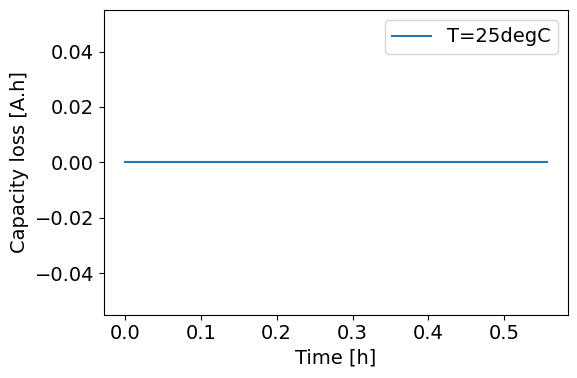

In [42]:
font = {'family' : 'DejaVu Sans','size'   : 14}
mpl.rc('font', **font)
fig, axs = plt.subplots(figsize=(6,4),tight_layout=True)
for T,sol in zip(T_All,Sol):
    axs.plot(
        sol["Time [h]"].entries-sol["Time [h]"].entries[0],
        sol["Total capacity lost to side reactions [A.h]"].entries,
        label = f"T={T}degC"
        )
axs.legend()
axs.set_xlabel("Time [h]")
axs.set_ylabel(r'Capacity loss [A.h]')